### 1. Class 

In [ ]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist
import numpy as np
import matplotlib.pyplot as plt
from coffea import lumi_tools
import glob
from coffea.util import load, save

In [26]:
# ---> Class JW Processor
class JW_Processor(processor.ProcessorABC):

    # -- Initializer
    def __init__(self, year, sample_name):
        
        
        self._year = year
        # Trigger set
        self._doubleelectron_triggers = {
            "2018": [
                "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL",  # Recomended
            ]
        }

        # hist set
        self._accumulator = processor.dict_accumulator(
            {
                "sumw": processor.defaultdict_accumulator(float),


                # -- Kinematics -- #
                "mass": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("mass", "$m_{e+e-}$ [GeV]", 100, 0, 200),
                ),
            }
        )

    # -- Accumulator: accumulate histograms
    @property
    def accumulator(self):
        return self._accumulator

    # -- Main function : Process events
    def process(self, events):

        # Initialize accumulator
        out = self.accumulator.identity()
        dataset = sample_name

        # Data or MC
        isData = "genWeight" not in events.fields
        
        # Golden Json file
        if (self._year == "2018") and isData:
            injson = "/x5/cms/jwkim/gitdir/JWCorp/JW_analysis/Coffea_WZG/Corrections/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt.RunABD"

        # << Sort by PT  helper function >>
        def sort_by_pt(ele,pho,jet):
            ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
            pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
            jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

            return ele,pho,jet
        events.Electron, events.Photon, events.Jet = sort_by_pt(
            events.Electron, events.Photon, events.Jet
        )

        # Golden Json file
        if (year == "2018") and isData:
            injson = "data/json/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt.RunABD"

        if isData:
            lumi_mask_builder = lumi_tools.LumiMask(injson)
            lumimask = ak.Array(
                lumi_mask_builder.__call__(events.run, events.luminosityBlock)
            )
            events = events[lumimask]


        # double lepton trigger
        is_double_ele_trigger=True
        if not is_double_ele_trigger:
            double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
        else:
            double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
            for path in self._doubleelectron_triggers[year]:
                if path not in events.HLT.fields: continue
                double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


        # Sort particle order by PT  # RunD --> has problem
        events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

        # Apply trigger
        Initial_events = events
        events = events[double_ele_triggers_arr]
        print("Events passing triggers and skiimig: ",len(events) )
        # Set Particle
        Electron = events.Electron
        ##----------- Cut flow2: Electron Selection

        EleSelmask = (
            (Electron.pt >= 10)
            & (np.abs(Electron.eta + Electron.deltaEtaSC) < 1.479)
            & (Electron.cutBased > 2)
            & (abs(Electron.dxy) < 0.05)
            & (abs(Electron.dz) < 0.1)
        ) | (
            (Electron.pt >= 10)
            & (np.abs(Electron.eta + Electron.deltaEtaSC) > 1.479)
            & (np.abs(Electron.eta + Electron.deltaEtaSC) <= 2.5)
            & (Electron.cutBased > 2)
            & (abs(Electron.dxy) < 0.1)
            & (abs(Electron.dz) < 0.2)
        )

        Electron = Electron[EleSelmask]

        # apply cut 2
        Diele_mask = ak.num(Electron) == 2
        Electron = Electron[Diele_mask]
        events = events[Diele_mask]

        diele = Electron[:,0] + Electron[:,1]

        # OSSF
        ossf_mask = (diele.charge == 0)

        # Z mass window
        Mee_cut_mask = diele.mass > 10

        # Electron PT cuts
        Elept_mask = (Electron[:,0].pt >= 25) & (Electron[:,1].pt >= 10)

        # Mask
        Event_sel_mask = Elept_mask & ossf_mask & Mee_cut_mask

        diele = diele[Event_sel_mask]
        Electron = Electron[Event_sel_mask]
        events = events[Event_sel_mask]

        # Fill hist
        Mee_arr = diele.mass
        out["sumw"][dataset] += len(Initial_events)
        out["mass"].fill(
            dataset=dataset,mass=Mee_arr
        )
        return out

    # -- Finally! return accumulator
    def postprocess(self, accumulator):
        return accumulator

### 2. Executor 

In [30]:
if __name__ == "__main__":
    
    file_list = glob.glob("../data/DY/*.root")
    year='2018'
    sample_name = 'DY'
    samples = {sample_name:file_list}
    # Class tio object
    JW_Processor_instance = JW_Processor(year, sample_name)
    
    
    ## -->Multi-node Executor
    result = processor.run_uproot_job(
        samples,  # dataset
        "Events",  # Tree name
        JW_Processor_instance,  # Class
        executor=processor.futures_executor,
        executor_args={"schema": NanoAODSchema, "workers": 4}, # number of CPU
    )    
    
    outname = sample_name + ".futures"
    save(result, outname)

Processing:   0%|          | 0/2 [00:00<?, ?chunk/s]

### 3. Draw 

In [32]:
import os
import numpy as np
from coffea.util import load, save
import matplotlib.pyplot as plt
import coffea.hist as hist
import time
import sys

In [82]:
hsum_Mee = hist.Hist(
	"Events",
	hist.Cat("dataset","Dataset"),
	hist.Bin("mass","Z mass",100,0,200)	
)

histdict = {'mass':hsum_Mee}

In [83]:
def reduce(folder,sample_list,histname):
	hists={}
	

	for filename in os.listdir(folder):
        
		hin = load(folder + '/' + filename)
		hists[filename] = hin.copy()
		
		if filename.split('.')[0] not in sample_list:
			continue

		hist_ = histdict[histname]
		hist_.add(hists[filename][histname])
	return hist_


In [84]:
file_path = 'output'
sample_list = ['DY']
histname = 'mass'
h1  = reduce(file_path,sample_list,histname)

In [85]:
## --Noramlize
lumi_factor = 59.971
scales={
   'DY'      : lumi_factor * 1000  * 2137.0 / 1933600,
}
h1.scale(scales,axis='dataset')

#h1 = h1.rebin(histname,hist.Bin("mass","Z mass",100,50,150))

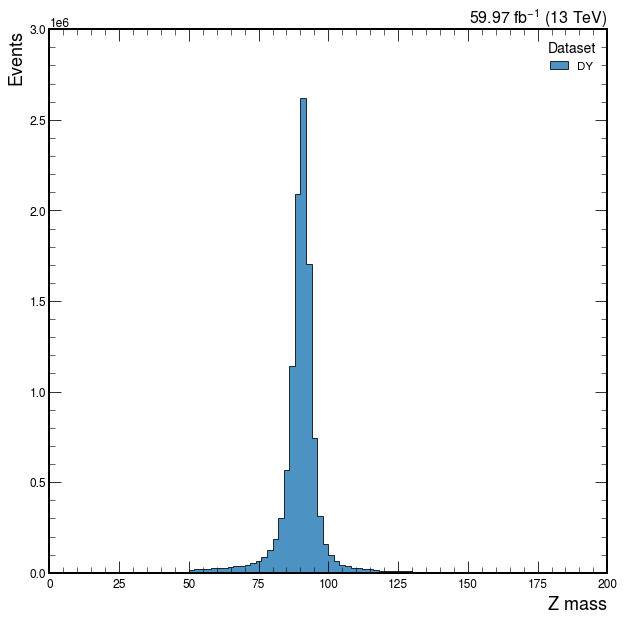

In [86]:
import mplhep as hep

XMIN=0
XMAX=200
YMIN=0
YMAX=3000000


plt.style.use(hep.style.CMS)

plt.rcParams.update({
	'font.size': 14,
	'axes.titlesize': 18,
	'axes.labelsize': 18,
	'xtick.labelsize': 12,
	'ytick.labelsize': 12
})

fig, ax = plt.subplots(
	nrows=1,
	ncols=1,
	figsize=(10,10),
	sharex=True
)
    
from cycler import cycler
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

hist.plot1d(
    h1['DY'],
    ax=ax,
    clear=False,
    #stack=True,
    fill_opts=fill_opts,
    error_opts = error_opts,
)

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
ax.autoscale(axis="x", tight=True)
ax.set_ylim(YMIN, YMAX)
ax.set_xlim(XMIN, XMAX)

lum = plt.text(
    1.0,
    1.0,
    r"%.2f fb$^{-1}$ (13 TeV)" % (lumi_factor),
    fontsize=16,
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
)

